# ISWD projekt 3

Autorzy:
* Patryk Hubicki 145253
* Jędrzej Kościelniak 145260

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split, StratifiedKFold
from xgboost import XGBClassifier, plot_tree, plot_importance


import copy
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm
from torchmetrics.classification import BinaryF1Score, BinaryAUROC
from torcheval.metrics.aggregation.auc import AUC
from torchviz import make_dot

import shap

from helpers import Train, CreateDataLoader
from ch_constr import ChoquetConstrained

c:\Users\Patryk\AppData\Local\Programs\Python\Python310\lib\site-packages\shap\utils\_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
c:\Users\Patryk\AppData\Local\Programs\Python\Python310\lib\site-packages\shap\utils\_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for detail

In [ ]:
from anchor import anchor_tabular

## Analiza zbioru danych

Zbiór danych to "memmographic"
Zbiór składa się z 830 instancji, które posiadają 6 znormalizowanych cech i należą do jednej z dwóch klas.

In [3]:
df = pd.read_csv("data/mammographic.csv", header=None)
df.columns = ["feat_1", "feat_2", "feat_3", "feat_4", "feat_5", "class"]
df.head()

,feat_1,feat_2,feat_3,feat_4,feat_5,class
0,0.090909,0.628205,0.666667,1.00,0.666667,1.0
1,0.090909,0.512821,1.000000,1.00,0.666667,1.0
2,0.072727,0.128205,0.000000,0.00,0.666667,0.0
3,0.090909,0.500000,0.000000,1.00,0.666667,1.0
4,0.090909,0.743590,0.000000,0.75,0.666667,1.0


In [4]:
df["class"].value_counts()

0.0    427
1.0    403
Name: class, dtype: int64

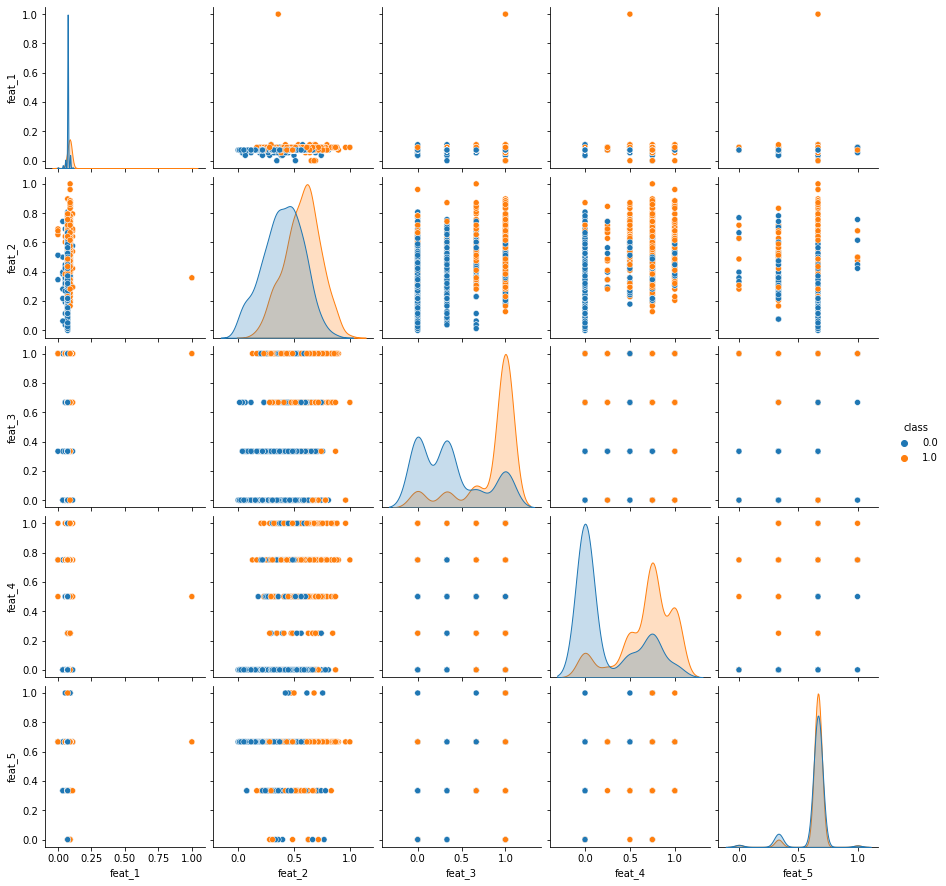

In [5]:
sns.pairplot(df, hue="class")
plt.show()

In [6]:
X = df.drop(columns=["class"])
y = df.loc[:, "class"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

## XGBoost

In [7]:
model = XGBClassifier(max_depth=4, max_leaves=10)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=10,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

### Wyniki modelu na zbiorze testowym

In [8]:
preds = model.predict(X_test)

acc = accuracy_score(y_test, preds)
auc = roc_auc_score(y_test, preds)
f1 = f1_score(y_test, preds)

print(f"Accuracy score: {acc:.2f}")
print(f"AUC score: {auc:.2f}")
print(f"F1 score: {f1:.2f}")

Accuracy score: 0.81
AUC score: 0.82
F1 score: 0.78


### Schemat drzewa decyzyjnego

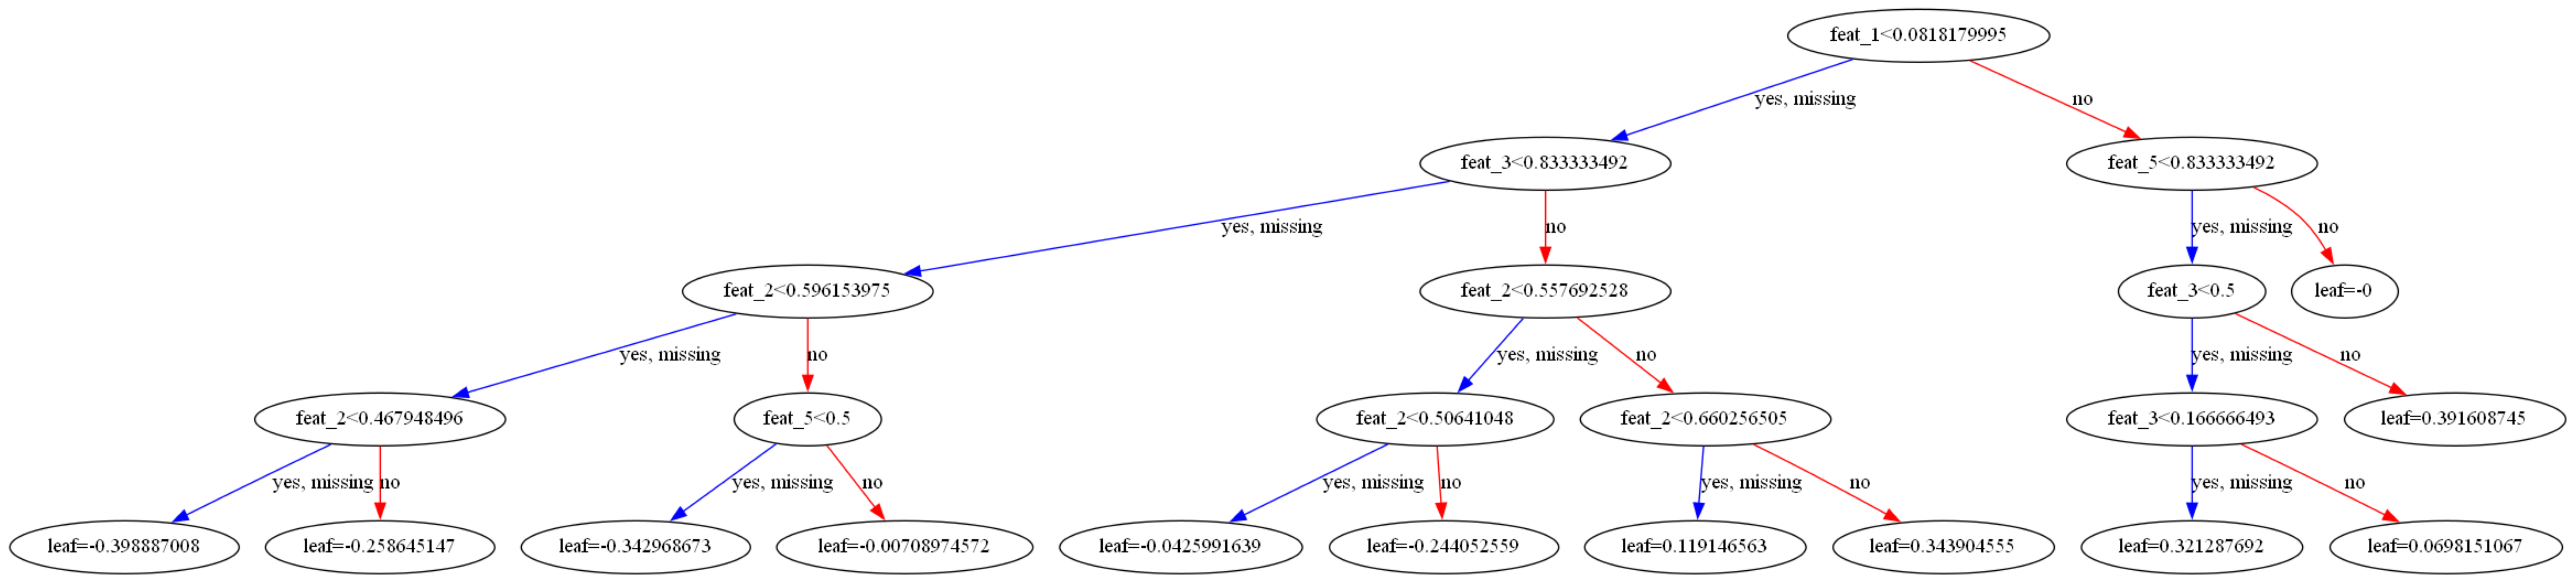

In [9]:
fig, ax = plt.subplots(figsize=(80, 100))
plot_tree(model, ax=ax, num_trees=1)
plt.show()

Liście zawierają oszacowania z ich odpowiedniego uczenia bazowego w dziedzinie funkcji, w której odbywa się procedura wzmacniania gradientowego. W przypadku przedstawionego zadania klasyfikacji binarnej zastosowanym powiązaniem jest logit, więc te szacunki reprezentują szanse logarytmiczne. Aby uzyskać szacunki prawdopodobieństwa, po prostu używamy funkcji logistycznej $\frac{1}{1+e^{-leafvalue}}$. Dla wartości liścia równego 0 otrzymamy równe prawdopodobięństwo przynależności do klas. Wartości mniejsze od zera wskazują na klasę negatywną (w naszym przypadku, klasę z etykietą równą 0), a wartości większę od zera w liściu dają większe prawdopodbienstwo klasie pozytywnej (klasie z etykietą równą 1).

Analizująć drzewo decyzyjne, możemy wyróżnić trzy poddrzewa. W lewej stronie wykresu poniżej warunku `feat_2 < 0.48` wszystkie liściue mają wartości ujemne, przez co w tej części drzewa zwrócona zostanie klasa negatywna (z większym bądź mniejszym prawdopodbieństwem). W prawej częsci drzewa prawie zawsze zostanie zwrócona klasa pozytywna (z wyjątkiem jednego liścia gdzie znajdziemy równe prawdopodbięnstwo dla obu klas). Środkowa część drzewa, dla warunku `feat_3 < 0.83` i odpowiedź `no` zwracana jest zarówno klasa negatywana jak i klasa pozytywna.

Możemy zatem stweirdzić, że dla wartości `feat_1` powyżej wartości 0.08 zwrócona zostanie klasa pozytywna, natomiast dla przykładów, które na `feat_1` mają wartości mniejsze niż 0.08 oraz na `feat_3` mają wartości mniejsze od 0.83, zwrócona zostanie klasa negatywna. W pozostałych przypadkach może zostać zwrócona klasa pozytywna jak i negatywna,w zależności od wartości na kryterium `feat_2`.

Analizując atrybuty wykorzystane do klasyfikacji, można wyodrębnić kryteria które mają wpływ decydujący, oraz kryteria które nie maja żadnego wpływu na decyzje. Do tej pierwszej grupy zaliczymy kryteria: `feat_1`, `feat_3` oraz `feat_2`. Natomiast w drugiej grupie znajdizemy `feat_5` oraz `feat_4`, które znajdują się w podrzewach dla których liscie zwracają jedną klasą, ale z różnymi prawdopodbieństwami. Przez co wartości na tych kryteriach nie zmienią decyzji modelu.

### Istotność cech

Analiza cech została wykonana z wykorzystaniem dwóch metod. `plot_importance` z pakietu `xgboost` wskazuje na to ile razy dana cecha została wykorzystana do przeprowadzenia operacji podziału w drzewie decyzyjnym. Możemy zauważyć, że w tym wypadku była to głównia `feat_2`. Analizując drzewo decyzyjne opisane w poprzednimpunkcie możemy zauważyć, że kryterium to najczęsciej występuje na wykresie. `feat_4` oraz `feat_3` było wykorzystywane w podobnym stopniu. Troche mniej razy skorzytsaliśmy z `feat_1` oraz `feat_5`. To pierwsze kryterium znajduje się w korzeniu naszego drzewa i mocno wpływa na decyzje modelu.

Analiza przeprowadzona z wykorzytsaniem `permutation_importance` polega na zamianie wartości jednej cechy na losowe wartości i obserwacji, jak bardzo to wpływa na wydajność modelu. Widzimy, że model jest nbajbardziej czuły na zmianę wartości kryterium `feat_1`. Nie jest to zaskoczeni, gdyż właśnie to kryterium znajduje się w korzeniu drzewa decyzyjnego. Najmniej na zmianę decyzji modelu wpływa modyfikacja na kryterium `feat_5`, który w poprzednim punkcie zostało opisane jak kryterium nie wpływająca na decyzje modelu.

Przeprowadzone analizy pokrywają się częściowo z wnioskami z poprzedniego punktu.

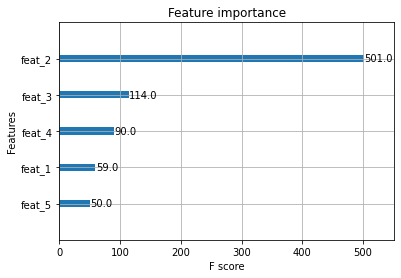

In [10]:
plot_importance(model)
plt.show()

<AxesSubplot:>

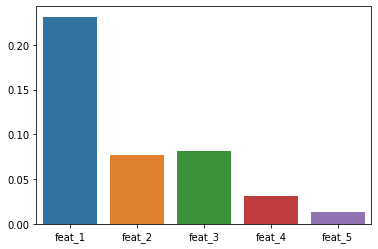

In [11]:
result = permutation_importance(model, X, y, n_repeats=10, random_state=0)
sns.barplot(x=X.columns, y=result["importances_mean"])

### Wyjaśnienie decyzji dla wybranych warinatów

**Minimalna zmina w ocenach potrzebna do zmiany decyzji**

Dla wybranych trzechg przykładów model zaklasyfikował dwa pierwsze warinaty do klasy 0 a trzeci wariant do klasy 1. Po dodaniu wartości 0.015 do `feat_1` dla dwóch pierwszych wariantów i odjęcie 0.15 od `feat_1` dla trzeceig warinatu odwraca predykcje modelu. Model jest czuły na zmianę wartości kryterium `feat_1` co pokzała analiza `permutation_importance`.

In [12]:
examples = df.sample(3, random_state=1).copy()
examples

,feat_1,feat_2,feat_3,feat_4,feat_5,class
786,0.072727,0.423077,0.000000,0.00,0.666667,0.0
522,0.072727,0.628205,0.333333,0.00,0.666667,0.0
811,0.090909,0.512821,0.666667,0.75,0.666667,1.0


In [13]:
model.predict(examples.drop(columns=["class"]))

array([0, 0, 1])

In [14]:
examples.iloc[0:2, 0] += 0.015
examples.iloc[2, 0] -= 0.015
examples

,feat_1,feat_2,feat_3,feat_4,feat_5,class
786,0.087727,0.423077,0.000000,0.00,0.666667,0.0
522,0.087727,0.628205,0.333333,0.00,0.666667,0.0
811,0.075909,0.512821,0.666667,0.75,0.666667,1.0


In [15]:
model.predict(examples.drop(columns=["class"]))

array([1, 1, 0])

**Wyjaśnieni decyzji przy użyciu Anchors LIME**

In [ ]:
explainer = anchor_tabular.AnchorTabularExplainer(["0", "1"], X.columns, X.to_numpy())

In [ ]:
for i, (_, example) in enumerate(examples.iterrows()):
    print(f"Example {i+1}: {list(example)}")
    example = pd.DataFrame(example).T.drop(columns=["class"]).reset_index(drop=True)
    exp = explainer.explain_instance(example.to_numpy(), model.predict, threshold=0.95)
    print('\tPrediction: ', explainer.class_names[model.predict(example).reshape(1, -1)[0][0]])
    print('\tAnchor: %s' % (' AND '.join(exp.names())))
    print('\tPrecision: %.2f' % exp.precision())
    print('\tCoverage: %.2f' % exp.coverage())

Example 1: [0.087727, 0.423077, 0.0, 0.0, 0.666667, 0.0]
	Prediction:  1
	Anchor: feat_1 > 0.07
	Precision: 0.99
	Coverage: 0.39
Example 2: [0.087727, 0.628205, 0.333333, 0.0, 0.666667, 0.0]
	Prediction:  1
	Anchor: feat_1 > 0.07
	Precision: 0.98
	Coverage: 0.39
Example 3: [0.075909, 0.512821, 0.666667, 0.75, 0.666667, 1.0]
	Prediction:  0
	Anchor: feat_3 <= 0.67 AND feat_2 <= 0.62 AND feat_4 <= 0.75 AND feat_1 <= 0.09 AND feat_5 <= 0.67
	Precision: 0.74
	Coverage: 0.45


Widać, że dla dwóch pierwszych przykłądów decyzja została podjęta na podstawie kryterium `feat_1`. Natomaist dla przykładu trzeciego decyzja została podjęta na podstawie wartości wszystkich 5 kryteriów.

## ANN-Ch-Constr

In [16]:
PATH = "choquet.pt"

In [17]:
def mobious_transform(row):
    return list(row) + [
        min(row[i], row[j]) for i in range(len(row)) for j in range(i + 1, len(row))
    ]

In [18]:
criteria_nr = 5

data_input = df.iloc[:, :criteria_nr].apply(
    lambda x: mobious_transform(x), axis=1, result_type="expand"
)
data_target = df.iloc[:, criteria_nr]

X_train, X_test, y_train, y_test = train_test_split(
    data_input.values, data_target.values, test_size=0.2, random_state=1234
)

In [19]:
train_dataloader = CreateDataLoader(X_train, y_train)
test_dataloader = CreateDataLoader(X_test, y_test)

In [20]:
model = ChoquetConstrained(criteria_nr)

### Wyniki modelu na zbiorze testowym i treningowym

In [21]:
acc, acc_test, auc, auc_test, f1, f1_test = Train(model, train_dataloader, test_dataloader, PATH)

print("Accuracy train:\t%.2f%%" % (acc * 100.0))
print("AUC train: \t%.2f%%" % (acc_test * 100.0))
print("Accuracy test:\t%.2f%%" % (auc * 100.0))
print("AUC test: \t%.2f%%" % (auc_test * 100.0))
print("F1 test:\t%.2f%%" % (f1 * 100.0))
print("F1 test: \t%.2f%%" % (f1_test * 100.0))

100%|██████████| 200/200 [00:07<00:00, 27.78it/s]

Accuracy train:	81.63%
AUC train: 	74.70%
Accuracy test:	84.31%
AUC test: 	83.73%
F1 test:	79.60%
F1 test: 	73.42%


In [22]:
checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint["model_state_dict"])

<All keys matched successfully>

### Istotność cech

Shapley Values są wykorzystywane do oceny wkładu poszczególnych cech w predykcje modelu. Obliczenie Shapley Values dla danej cechy polega na obliczeniu różnicy w predykcji modelu z uwzględnieniem tej cechy w porównaniu do predykcji bez uwzględniania tej cechy.

In [23]:
weights = model.criteria_layer.w().detach().numpy()[0]
interaction_weights = model.interaction_layer.w().detach().numpy()[0]
s = weights.sum() + interaction_weights.sum()
weights = weights / s
interaction_weights = interaction_weights / s

interactions = np.zeros((criteria_nr, criteria_nr))
weight_id = 0
for i in range(criteria_nr):
    for j in range(i + 1, criteria_nr):
        interactions[i, j] = interactions[j, i] = interaction_weights[weight_id]
        weight_id += 1

Criteria weights:
[0.374, 0.0451, 0.0, 0.0, 0.2785]


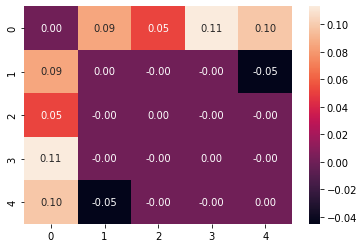

In [24]:
print("Criteria weights:")
print([round(weight, 4) for weight in weights])

sns.heatmap(interactions, annot=True, fmt='.2f')
plt.show()

In [25]:
shapley = weights + interactions.sum(0) / 2
print("Importance of criterina (Shapley value):")
print(shapley)

Importance of criterina (Shapley value):
[0.54773695 0.06512333 0.0258536  0.05650606 0.30478009]


Po przeprowadzonej analizie widać że dla modelu największa istotność ma kryterium pierwsze oraz (w mniejszym stopniu) kryterium piąte. Najniższe wagi zostały przypisane kryterium od drugiego do czwartego.

### Interpretacja modelu

Jako próbę wyjasnienia działania modelu wykorzystaliśmy podejście podobne do działania `PartialDependenceDisplay` z pakietu `sklearn`. Dla każdego kryterium bierzemy jego unikalne wartości i liczymy jakie są średnie predykcje modelu dla każdej z tych wartości. Na podstawie tego jesteśmy w stanie zauważyć jak zmieniają się predykcje modelu w raz ze zmianą wartości danego kryterium.

Poniżej zostały przedstawione 5 wykresów (jeden dla każdej z cech). Dla predykcji modelu poniżej wartości 0, bardziej prawdopodbna jest klasa negatywna. W przeciwnym wypadku bardziej prawdopdona jest klasa pozytywna. Widzimy że dla kryterium pierwszego oraz piątego przebieg funkcji jest rosnący, co oznacza że większe wartości na tych kryteriach zwiększaja szanse na klasę pozytywną. Były to dwa najważniejsze kryteria według analizy z poprzedniego punktu. Kryterium drugie ma mocno nie monotoniczny przebieg. Kryterium trzecie oraz czwarte mają małą liczbę przełamań.

In [26]:
with torch.no_grad():
    y_pred = model(torch.Tensor(data_input.values))

all_mean_preds = []
for i in range(criteria_nr):
    criterium_values = torch.Tensor(data_input.iloc[:, i])
    mean_preds = []
    for value in torch.unique(criterium_values):
        mask = (criterium_values == value)
        mean_pred = torch.mean(y_pred[mask])
        mean_preds.append(mean_pred.item())
    all_mean_preds.append(mean_preds)

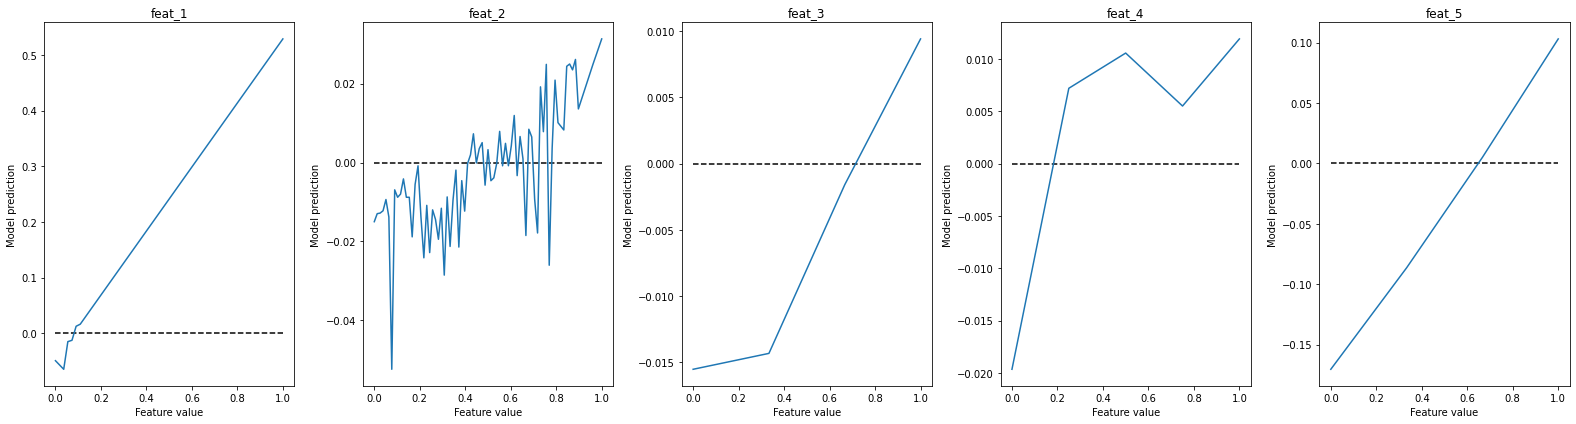

In [27]:
fig, axes = plt.subplots(1, criteria_nr, figsize=(22, 6))

for i in range(criteria_nr):
    axes[i].hlines(y=0, xmin=[0.0], xmax=[1.0], colors="black", linestyle="--")
    axes[i].plot(torch.unique(torch.Tensor(data_input.iloc[:, i])), all_mean_preds[i], zorder=2)
    axes[i].set_title(f'feat_{i+1}')
    axes[i].set_xlabel("Feature value")
    axes[i].set_ylabel("Model prediction")

plt.tight_layout()

### Wyjaśnienie decyzji dla wybranych warinatów

**Minimalna zmina w ocenach potrzebna do zmiany decyzji**

Dla wybranych trzechg przykładów model zaklasyfikował dwa pierwsze warinaty do klasy 0 a trzeci wariant do klasy 1. Po dodaniu wartości 0.02 do pierwszej kolumny dla dwóch pierwszych wariantów i odjęcie 0.04 od pierwszej kolumny dla trzeciego warinatu odwraca predykcje modelu.

In [28]:
indieces = df.sample(3, random_state=1).index
examples = data_input.values[indieces].copy()
examples

array([[0.072727, 0.423077, 0.      , 0.      , 0.666667, 0.072727,
        0.      , 0.      , 0.072727, 0.      , 0.      , 0.423077,
        0.      , 0.      , 0.      ],
       [0.072727, 0.628205, 0.333333, 0.      , 0.666667, 0.072727,
        0.072727, 0.      , 0.072727, 0.333333, 0.      , 0.628205,
        0.      , 0.333333, 0.      ],
       [0.090909, 0.512821, 0.666667, 0.75    , 0.666667, 0.090909,
        0.090909, 0.090909, 0.090909, 0.512821, 0.512821, 0.512821,
        0.666667, 0.666667, 0.666667]])

In [29]:
with torch.no_grad():
    y_pred = model(torch.Tensor(examples))
y_pred

tensor([[-0.0088],
        [-0.0050],
        [ 0.0163]])

In [30]:
examples[0:2, 0] += 0.02
examples[2, 0] -= 0.04
examples

array([[0.092727, 0.423077, 0.      , 0.      , 0.666667, 0.072727,
        0.      , 0.      , 0.072727, 0.      , 0.      , 0.423077,
        0.      , 0.      , 0.      ],
       [0.092727, 0.628205, 0.333333, 0.      , 0.666667, 0.072727,
        0.072727, 0.      , 0.072727, 0.333333, 0.      , 0.628205,
        0.      , 0.333333, 0.      ],
       [0.050909, 0.512821, 0.666667, 0.75    , 0.666667, 0.090909,
        0.090909, 0.090909, 0.090909, 0.512821, 0.512821, 0.512821,
        0.666667, 0.666667, 0.666667]])

In [31]:
with torch.no_grad():
    y_pred = model(torch.Tensor(examples))
y_pred

tensor([[-0.0013],
        [ 0.0024],
        [ 0.0013]])

## Złożony model sieci neuronowej

In [32]:
X_tens = torch.tensor(X.values, dtype=torch.float32)
y_tens = torch.tensor(y, dtype=torch.float32).reshape(-1, 1)

In [36]:
class Deep_Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(5, 5)
        self.act1 = nn.ReLU()
        self.layer2 = nn.Linear(5, 5)
        self.act2 = nn.ReLU()
        self.layer3 = nn.Linear(5, 5)
        self.act3 = nn.ReLU()
        self.output = nn.Linear(5, 1)
        self.sigmoid = nn.Sigmoid()
 
    def forward(self, x):
        x = self.act1(self.layer1(x))
        x = self.act2(self.layer2(x))
        x = self.act3(self.layer3(x))
        x = self.sigmoid(self.output(x))
        return x

In [37]:
def model_train(model, X_train, y_train, X_val, y_val):
    loss_fn = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    n_epochs = 200
    batch_size = 10
    batch_start = torch.arange(0, len(X_train), batch_size)

    best_acc = - np.inf
    best_weights = None

    for epoch in range(n_epochs):
        print(epoch, end=" ")
        model.train()
        with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
            bar.set_description(f"Epoch {epoch}")
            for start in bar:
                X_batch = X_train[start:start+batch_size]
                y_batch = y_train[start:start+batch_size]
                y_pred = model(X_batch)
                loss = loss_fn(y_pred, y_batch)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                acc = (y_pred.round() == y_batch).float().mean()
                bar.set_postfix(
                    loss=float(loss),
                    acc=float(acc)
                )
        model.eval()
        y_pred = model(X_val)
        acc = (y_pred.round() == y_val).float().mean()
        acc = float(acc)
        if acc > best_acc:
            best_acc = acc
            best_weights = copy.deepcopy(model.state_dict())
    model.load_state_dict(best_weights)
    return best_acc

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X_tens, y_tens, train_size=0.75, shuffle=True)
model = Deep_Model()
acc = model_train(model, X_train , y_train, X_test, y_test)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 

### Miary jakości ###

In [45]:
preds = model(X_tens)
print("Accuracy: ", round(acc, 4))
metric = BinaryF1Score()
print("F1: ", metric(preds, y_tens))
metric = BinaryAUROC(thresholds=None)
print("AUC: ", metric(preds, y_tens))

Accuracy:  0.7596
F1:  tensor(0.8076)
AUC:  tensor(0.8448)


### Wizualizacja ###

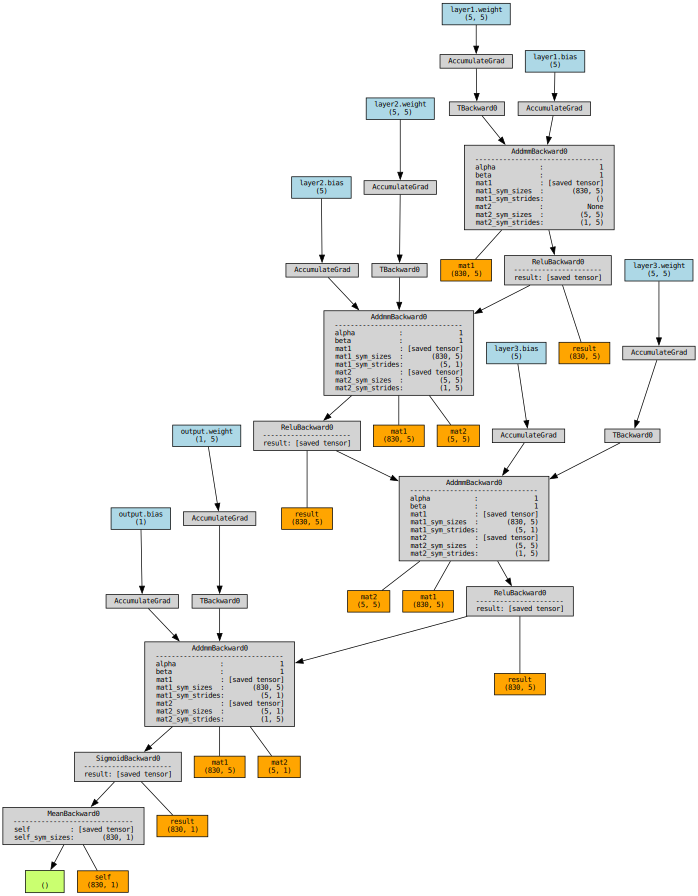

In [47]:
make_dot(preds.mean(), params=dict(model.named_parameters()), show_attrs=True, show_saved=True)

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


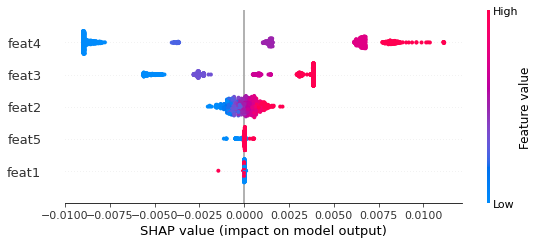

In [49]:
explainer = shap.DeepExplainer(model, X_tens)
shap_values = explainer.shap_values(X_tens)
shap.summary_plot(shap_values, X_tens, feature_names=["feat1", "feat2", "feat3", "feat4", "feat5"])

Najważniejszą cechą do klasyfikacji jest cecha 4. Ma ona zdecydownie największy wpływ. Duży wpływ ma też cecha 2 i 3. Cecha 1 i 5 nie mają prawie wpływu na klasyfikację wariantu.

In [51]:
X.head()

,feat_1,feat_2,feat_3,feat_4,feat_5
0,0.090909,0.628205,0.666667,1.00,0.666667
1,0.090909,0.512821,1.000000,1.00,0.666667
2,0.072727,0.128205,0.000000,0.00,0.666667
3,0.090909,0.500000,0.000000,1.00,0.666667
4,0.090909,0.743590,0.000000,0.75,0.666667


### Interpretacja modelu

Jako próbę wyjasnienia działania modelu po raz kolejny wykorzystaliśmy podejście podobne do działania `PartialDependenceDisplay` z pakietu `sklearn`.

Poniżej został przedstawiony wykres. Dla predykcji modelu poniżej wartości 0.5, bardziej prawdopodbna jest klasa negatywna. W przeciwnym wypadku bardziej prawdopdona jest klasa pozytywna. Widzimy że kryterium czwarte dla małych wartości wspiera klasę negatywną, a dla dużych klasą pozytywną. Jaka jedyna też ma aż tak duży przedział średnich wartości (0.49 - 0.51) co pokazuje, iż jest ważna dla klasyfikacji.

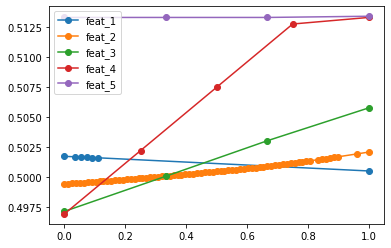

In [87]:
copy = X.copy()
for name in ["feat_1", "feat_2", "feat_3", "feat_4", "feat_5"]:
    uniq = copy[name].unique()
    y_val = []
    uniq = np.sort(uniq)
    for x in uniq:
        copy[name] = x
        pred = model(torch.tensor(copy.values, dtype=torch.float32))
        y_val.append(torch.mean(pred).detach().numpy().item())
    plt.plot(uniq, y_val, 'o-', label = name)
    plt.legend(["feat_1", "feat_2", "feat_3", "feat_4", "feat_5"])